# Preliminary operation and Import Packages

2.9 version of TensorFlow/Keras, because some data augmentation techniques are particularly slow

In [1]:
!nvidia-smi

Thu Feb  9 19:26:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   58C    P8    N/A /  N/A |   1803MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3053378521526046220
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1297474971
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2118325974425920900
physical_device_desc: "device: 0, name: NVIDIA GeForce MX450, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
# Keras e TF

import tensorflow as tf 
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Conv1D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, AveragePooling2D, Input, Flatten, Dropout
from keras.callbacks import ModelCheckpoint

# Sk-Learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay, accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.utils import shuffle

# Base
import os 
from matplotlib import pyplot as plt
import seaborn as sns # 
import numpy as np #
import pandas as pd # 

import pydot
import pydotplus
from pydotplus import graphviz

# Image generator

In [14]:
batch_size = 32 

train_path = 'C:/Users/marco/OneDrive/UNIMIB_DataScience/99-PROJECTS/DSIM_Project/chest-xrays-classification-generation/AC-cGAN/generated_images/epoch_288_classification'
validation_path = 'C:/Users/marco/Desktop/Local_Documents/data/COVIDx-splitted-resized-112/train'
test_path = 'C:/Users/marco/Desktop/Local_Documents/data/COVIDx-splitted-resized-112/test'

train_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.15)
test_datagen = ImageDataGenerator(rescale=1./255.)

In [11]:
train_data = train_datagen.flow_from_directory(
        train_path,  
        target_size=(112, 112),  # Lo inserisco per precauzione
        batch_size=batch_size,
        seed=123,
        shuffle=True,
        subset='training',
        class_mode='categorical')

Found 20892 images belonging to 3 classes.


In [12]:
validation_data = train_datagen.flow_from_directory(
        validation_path,  
        target_size=(112, 112),  # Lo inserisco per precauzione
        batch_size=batch_size,
        seed=123,
        shuffle=True,
        subset='validation',
        class_mode='categorical')

Found 4409 images belonging to 3 classes.


In [15]:
# Test set
test_data = test_datagen.flow_from_directory(
        test_path,  
        target_size=(112, 112),  # Lo inserisco per precauzione
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 397 images belonging to 3 classes.


# Architecture Definition

In [16]:
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [40]:
version = "v1"
img_size = '112'
checkpoint_filepath = f'C:/Users/marco/Desktop/Local_Documents/models/AC-cGAN_classification/dcnn_model_{img_size}_{version}_val_acc_best.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [50]:
num_classes = 3
inputs = keras.Input((112,112,3))

x = inputs

x = keras.layers.Conv2D(16, 3, padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(32, 3,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(3,3), strides=(3,3))(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Conv2D(64, 3,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(128, 2,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.MaxPooling2D(pool_size=(2,2), strides=(3,3))(x)

x = keras.layers.Dropout(0.2)(x)

# x = keras.layers.GlobalMaxPool2D()(x)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)

# x = keras.layers.Dense(512, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)

# x = keras.layers.Dense(1000, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
net_dcnn_112_ACcgan = keras.Model(inputs, outputs)



In [51]:
net_dcnn_112_ACcgan.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 16)      448       
                                                                 
 activation_12 (Activation)  (None, 112, 112, 16)      0         
                                                                 
 batch_normalization_6 (Batc  (None, 112, 112, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 activation_13 (Activation)  (None, 112, 112, 32)      0         
                                                           

# Model fit

In [42]:
METRICS = [ 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.TopKCategoricalAccuracy(name='top 2 accuracy', k=2),
      keras.metrics.TopKCategoricalAccuracy(name='top 3 accuracy', k=3),
      keras.metrics.TopKCategoricalAccuracy(name='top 5 accuracy', k=5),
]
OPTIMIZER = keras.optimizers.Adam(learning_rate=0.0001)

In [43]:
# batch size 
step_per_epoch_train = len(train_data.labels) // batch_size
print(step_per_epoch_train)
step_per_epoch_val = len(validation_data.labels) // batch_size
print(step_per_epoch_val)

652
137


In [52]:
net_dcnn_112_ACcgan.compile(loss=keras.losses.categorical_crossentropy,
            optimizer = OPTIMIZER,
            metrics=METRICS)

In [53]:
history_dcnn_ACcgan = net_dcnn_112_ACcgan.fit(train_data,
          epochs=15,
          steps_per_epoch=step_per_epoch_train,
          validation_data=validation_data,
          validation_steps=step_per_epoch_val,
          workers = 3,
          callbacks=[model_checkpoint_callback, early_stopper])

Epoch 1/15
652/652 [==============================] - 62s 92ms/step - loss: 0.0946 - accuracy: 0.9728 - precision: 0.9771 - recall: 0.9698 - auc: 0.9975 - top 2 accuracy: 0.9934 - top 3 accuracy: 1.0000 - top 5 accuracy: 1.0000 - val_loss: 1.3994 - val_accuracy: 0.6720 - val_precision: 0.6752 - val_recall: 0.6686 - val_auc: 0.8267 - val_top 2 accuracy: 0.9085 - val_top 3 accuracy: 1.0000 - val_top 5 accuracy: 1.0000
Epoch 2/15
652/652 [==============================] - 58s 89ms/step - loss: 0.0091 - accuracy: 0.9975 - precision: 0.9976 - recall: 0.9974 - auc: 1.0000 - top 2 accuracy: 1.0000 - top 3 accuracy: 1.0000 - top 5 accuracy: 1.0000 - val_loss: 1.7295 - val_accuracy: 0.7044 - val_precision: 0.7065 - val_recall: 0.7023 - val_auc: 0.8433 - val_top 2 accuracy: 0.9167 - val_top 3 accuracy: 1.0000 - val_top 5 accuracy: 1.0000
Epoch 3/15
652/652 [==============================] - 58s 89ms/step - loss: 0.0058 - accuracy: 0.9983 - precision: 0.9985 - recall: 0.9981 - auc: 1.0000 - top 2

In [54]:
np.save(f'C:/Users/marco/Desktop/Local_Documents/models/AC-cGAN_classification/dcnn_history_{img_size}_{version}.npy',
        history_dcnn_ACcgan.history)

Visualization of the learning curves

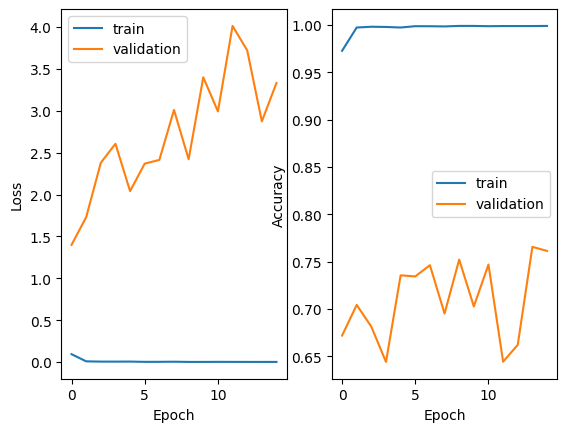

In [55]:
# Loss
plt.subplot(1, 2, 1)
plt.plot(history_dcnn_ACcgan.history['loss'])
plt.plot(history_dcnn_ACcgan.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dcnn_ACcgan.history['accuracy'])
plt.plot(history_dcnn_ACcgan.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])

# Load Model

In [35]:
os.chdir('C:/Users/marco/Desktop/Local_Documents/models/AC-cGAN_classification')

In [36]:
# Load model
net_dcnn_112_ACcgan = keras.models.load_model("dcnn_model_112_v1_val_acc_best.hdf5")

In [57]:
# Load hystory and convert to dict
history = np.load('dcnn_history_112_v1.npy', allow_pickle=True).item()

# Model Evaluation

In [56]:
# Set visualization size for figures 
plt.rcParams['figure.figsize'] = [5,5] # width, height

In [64]:
CATEGORIES = "COVID", "NORMAL","PNEUMONIA"

In [58]:
history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'top 2 accuracy', 'top 3 accuracy', 'top 5 accuracy', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_top 2 accuracy', 'val_top 3 accuracy', 'val_top 5 accuracy'])

In [59]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history[item][0:index]
    plt.plot(train_values)
    test_values = history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)

In [60]:
def test_set_results(pred_value, n=1):    
    y_test = test_data.labels
    X_test, _ = test_data.next()
    
    corr_pred = confusion_matrix(y_test, pred_value)
    fig=plt.figure(figsize=(10, 8))
    ax = plt.axes()
    
    sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Purples", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
    ax.set_title('Confusione Matrix')
    plt.show()
    
    n_correct = int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])
    print('...'*15)

    print('> Correct Predictions:', n_correct)
    
    n_wrongs = len(y_test) - n_correct
    print('> Wrong Predictions:', n_wrongs)
    print('...'*15)
    
    print(classification_report(test_data.labels, pred_value, target_names=CATEGORIES))

In [61]:
def printResults(name, model):
    predictions = model.predict(test_data, verbose=1)
    preds = np.argmax(predictions, axis=1)
    test_set_results(preds)

In [62]:
def model_summary(model, history, name):
    val_acc = history['val_accuracy'] #validation accuracy history
    index= val_acc.index(max(val_acc))
    print('Best Epochs:', index)


    test_loss, test_accuracy, test_precision, test_recall, auc, _, _, _ = model.evaluate(test_data, verbose=1)

    train_accuracy = history['accuracy'][index]
    train_loss = history['loss'][index]

    print_graph('loss', index, history)
    print_graph('accuracy', index, history)

    print('---'*15) 
    print(name)
    print('> Accuracy on train:',round(train_accuracy, 2), 
            '\tLoss on train:', round(train_loss,2))
    

    print('> Accuracy on test:',round(test_accuracy, 2),
            '\tLoss on test:',round(test_loss,2))

    print('---'*15)
    print('> predicting test')
    print('---'*15)

    printResults(name, model)

Best Epochs: 13
13/13 [==============================] - 1s 41ms/step - loss: 5.8096 - accuracy: 0.6196 - precision: 0.6212 - recall: 0.6196 - auc: 0.7549 - top 2 accuracy: 0.9068 - top 3 accuracy: 1.0000 - top 5 accuracy: 1.0000


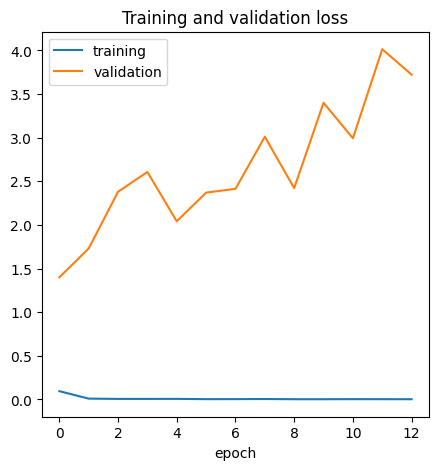

<Figure size 500x500 with 0 Axes>

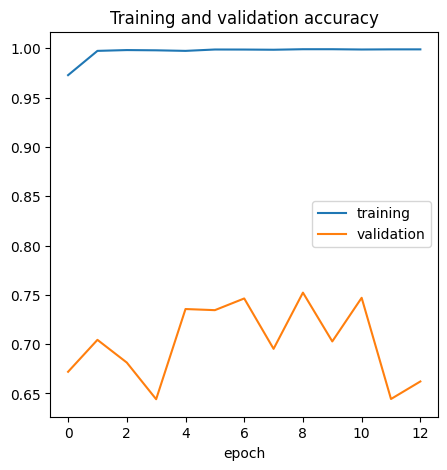

---------------------------------------------
DCCN - Test AC-cGAN
> Accuracy on train: 1.0 	Loss on train: 0.0
> Accuracy on test: 0.62 	Loss on test: 5.81
---------------------------------------------
> predicting test
---------------------------------------------
13/13 [==============================] - 1s 41ms/step


<Figure size 500x500 with 0 Axes>

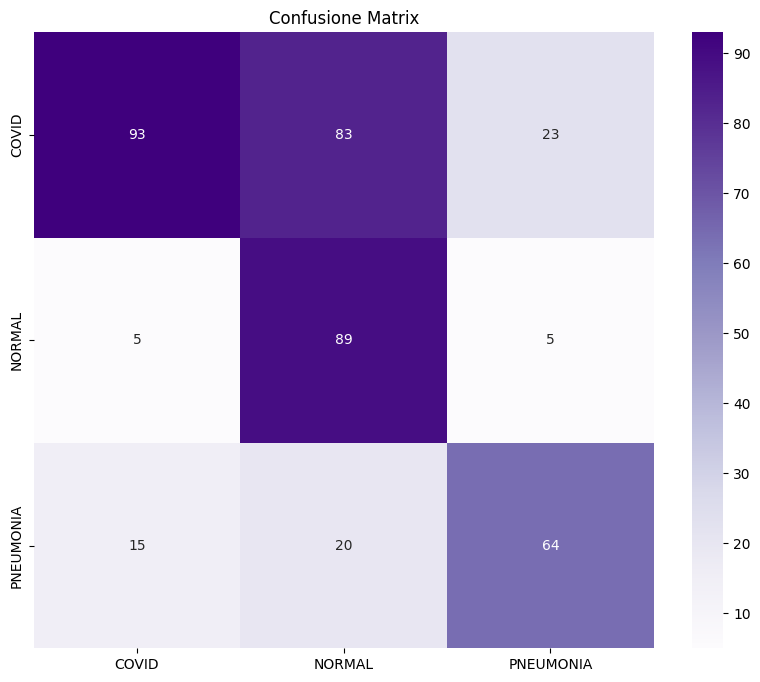

.............................................
> Correct Predictions: 246
> Wrong Predictions: 151
.............................................
              precision    recall  f1-score   support

       COVID       0.82      0.47      0.60       199
      NORMAL       0.46      0.90      0.61        99
   PNEUMONIA       0.70      0.65      0.67        99

    accuracy                           0.62       397
   macro avg       0.66      0.67      0.63       397
weighted avg       0.70      0.62      0.62       397



In [65]:
model_summary(net_dcnn_112_ACcgan, history, 'DCCN - Test AC-cGAN')